In [0]:
import cv2
import h5py
import imageio
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import Image
from keras import backend as K
from keras.engine import Input, Model

from keras.layers import (
    Activation,
    Conv3D,
    Deconvolution3D,
    MaxPooling3D,
    UpSampling3D,
)

from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.compat.v1.logging import INFO, set_verbosity

set_verbosity(INFO)

K.set_image_data_format("channels_first")


def plot_image_grid(image):
    data_all = []

    data_all.append(image)

    fig, ax = plt.subplots(3, 6, figsize=[16, 9])

    # coronal plane
    coronal = np.transpose(data_all, [1, 3, 2, 4, 0])
    coronal = np.rot90(coronal, 1)

    # transversal plane
    transversal = np.transpose(data_all, [2, 1, 3, 4, 0])
    transversal = np.rot90(transversal, 2)

    # sagittal plane
    sagittal = np.transpose(data_all, [2, 3, 1, 4, 0])
    sagittal = np.rot90(sagittal, 1)

    for i in range(6):
        n = np.random.randint(coronal.shape[2])
        ax[0][i].imshow(np.squeeze(coronal[:, :, n, :]))
        ax[0][i].set_xticks([])
        ax[0][i].set_yticks([])
        if i == 0:
            ax[0][i].set_ylabel('Coronal', fontsize=15)

    for i in range(6):
        n = np.random.randint(transversal.shape[2])
        ax[1][i].imshow(np.squeeze(transversal[:, :, n, :]))
        ax[1][i].set_xticks([])
        ax[1][i].set_yticks([])
        if i == 0:
            ax[1][i].set_ylabel('Transversal', fontsize=15)

    for i in range(6):
        n = np.random.randint(sagittal.shape[2])
        ax[2][i].imshow(np.squeeze(sagittal[:, :, n, :]))
        ax[2][i].set_xticks([])
        ax[2][i].set_yticks([])
        if i == 0:
            ax[2][i].set_ylabel('Sagittal', fontsize=15)

    fig.subplots_adjust(wspace=0, hspace=0)


def visualize_data_gif(data_):
    images = []
    for i in range(data_.shape[0]):
        x = data_[min(i, data_.shape[0] - 1), :, :]
        y = data_[:, min(i, data_.shape[1] - 1), :]
        z = data_[:, :, min(i, data_.shape[2] - 1)]
        img = np.concatenate((x, y, z), axis=1)
        images.append(img)
    imageio.mimsave("/tmp/gif.gif", images, duration=0.01)
    return Image(filename="/tmp/gif.gif", format='png')


# Some code was borrowed from:
# https://github.com/ellisdg/3DUnetCNN/blob/master/unet3d/


def create_convolution_block(input_layer, n_filters, batch_normalization=False,
                             kernel=(3, 3, 3), activation=None,
                             padding='same', strides=(1, 1, 1),
                             instance_normalization=False):
    """
    :param strides:
    :param input_layer:
    :param n_filters:
    :param batch_normalization:
    :param kernel:
    :param activation: Keras activation layer to use. (default is 'relu')
    :param padding:
    :return:
    """
    layer = Conv3D(n_filters, kernel, padding=padding, strides=strides)(
        input_layer)
    if activation is None:
        return Activation('relu')(layer)
    else:
        return activation()(layer)


def get_up_convolution(n_filters, pool_size, kernel_size=(2, 2, 2),
                       strides=(2, 2, 2),
                       deconvolution=False):
    if deconvolution:
        return Deconvolution3D(filters=n_filters, kernel_size=kernel_size,
                               strides=strides)
    else:
        return UpSampling3D(size=pool_size)


def unet_model_3d(loss_function, input_shape=(4, 160, 160, 16),
                  pool_size=(2, 2, 2), n_labels=3,
                  initial_learning_rate=0.00001,
                  deconvolution=False, depth=4, n_base_filters=32,
                  include_label_wise_dice_coefficients=False, metrics=[],
                  batch_normalization=False, activation_name="sigmoid"):
    """
    Builds the 3D UNet Keras model.f
    :param metrics: List metrics to be calculated during model training (default is dice coefficient).
    :param include_label_wise_dice_coefficients: If True and n_labels is greater than 1, model will report the dice
    coefficient for each label as metric.
    :param n_base_filters: The number of filters that the first layer in the convolution network will have. Following
    layers will contain a multiple of this number. Lowering this number will likely reduce the amount of memory required
    to train the model.
    :param depth: indicates the depth of the U-shape for the model. The greater the depth, the more max pooling
    layers will be added to the model. Lowering the depth may reduce the amount of memory required for training.
    :param input_shape: Shape of the input data (n_chanels, x_size, y_size, z_size). The x, y, and z sizes must be
    divisible by the pool size to the power of the depth of the UNet, that is pool_size^depth.
    :param pool_size: Pool size for the max pooling operations.
    :param n_labels: Number of binary labels that the model is learning.
    :param initial_learning_rate: Initial learning rate for the model. This will be decayed during training.
    :param deconvolution: If set to True, will use transpose convolution(deconvolution) instead of up-sampling. This
    increases the amount memory required during training.
    :return: Untrained 3D UNet Model
    """
    inputs = Input(input_shape)
    current_layer = inputs
    levels = list()

    # add levels with max pooling
    for layer_depth in range(depth):
        layer1 = create_convolution_block(input_layer=current_layer,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth),
                                          batch_normalization=batch_normalization)
        layer2 = create_convolution_block(input_layer=layer1,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth) * 2,
                                          batch_normalization=batch_normalization)
        if layer_depth < depth - 1:
            current_layer = MaxPooling3D(pool_size=pool_size)(layer2)
            levels.append([layer1, layer2, current_layer])
        else:
            current_layer = layer2
            levels.append([layer1, layer2])

    # add levels with up-convolution or up-sampling
    for layer_depth in range(depth - 2, -1, -1):
        up_convolution = get_up_convolution(pool_size=pool_size,
                                            deconvolution=deconvolution,
                                            n_filters=
                                            current_layer._keras_shape[1])(
            current_layer)
        concat = concatenate([up_convolution, levels[layer_depth][1]], axis=1)
        current_layer = create_convolution_block(
            n_filters=levels[layer_depth][1]._keras_shape[1],
            input_layer=concat, batch_normalization=batch_normalization)
        current_layer = create_convolution_block(
            n_filters=levels[layer_depth][1]._keras_shape[1],
            input_layer=current_layer,
            batch_normalization=batch_normalization)

    final_convolution = Conv3D(n_labels, (1, 1, 1))(current_layer)
    act = Activation(activation_name)(final_convolution)
    model = Model(inputs=inputs, outputs=act)

    if not isinstance(metrics, list):
        metrics = [metrics]

    model.compile(optimizer=Adam(lr=initial_learning_rate), loss=loss_function,
                  metrics=metrics)
    return model


def visualize_patch(X, y):
    fig, ax = plt.subplots(1, 2, figsize=[10, 5], squeeze=False)

    ax[0][0].imshow(X[:, :, 0], cmap='Greys_r')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    ax[0][1].imshow(y[:, :, 0], cmap='Greys_r')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])

    fig.subplots_adjust(wspace=0, hspace=0)


class VolumeDataGenerator(keras.utils.Sequence):
    def __init__(self,
                 sample_list,
                 base_dir,
                 batch_size=1,
                 shuffle=True,
                 dim=(160, 160, 16),
                 num_channels=4,
                 num_classes=3,
                 verbose=1):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.base_dir = base_dir
        self.dim = dim
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.verbose = verbose
        self.sample_list = sample_list
        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.sample_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.sample_list) / self.batch_size))

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'

        # Initialization
        X = np.zeros((self.batch_size, self.num_channels, *self.dim),
                     dtype=np.float64)
        y = np.zeros((self.batch_size, self.num_classes, *self.dim),
                     dtype=np.float64)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            if self.verbose == 1:
                print("Training on: %s" % self.base_dir + ID)
            with h5py.File(self.base_dir + ID, 'r') as f:
                X[i] = np.array(f.get("x"))
                # remove the background class
                y[i] = np.moveaxis(np.array(f.get("y")), 3, 0)[1:]
        return X, y

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[
                  index * self.batch_size: (index + 1) * self.batch_size]
        # Find list of IDs
        sample_list_temp = [self.sample_list[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(sample_list_temp)

        return X, y


def get_labeled_image(image, label, is_categorical=False):
    if not is_categorical:
        label = to_categorical(label, num_classes=4).astype(np.uint8)

    image = cv2.normalize(image[:, :, :, 0], None, alpha=0, beta=255,
                          norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(
        np.uint8)

    labeled_image = np.zeros_like(label[:, :, :, 1:])

    # remove tumor part from image
    labeled_image[:, :, :, 0] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 1] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 2] = image * (label[:, :, :, 0])

    # color labels
    labeled_image += label[:, :, :, 1:] * 255
    return labeled_image


def predict_and_viz(image, label, model, threshold, loc=(100, 100, 50)):
    image_labeled = get_labeled_image(image.copy(), label.copy())

    model_label = np.zeros([3, 320, 320, 160])

    for x in range(0, image.shape[0], 160):
        for y in range(0, image.shape[1], 160):
            for z in range(0, image.shape[2], 16):
                patch = np.zeros([4, 160, 160, 16])
                p = np.moveaxis(image[x: x + 160, y: y + 160, z:z + 16], 3, 0)
                patch[:, 0:p.shape[1], 0:p.shape[2], 0:p.shape[3]] = p
                pred = model.predict(np.expand_dims(patch, 0))
                model_label[:, x:x + p.shape[1],
                y:y + p.shape[2],
                z: z + p.shape[3]] += pred[0][:, :p.shape[1], :p.shape[2],
                                      :p.shape[3]]

    model_label = np.moveaxis(model_label[:, 0:240, 0:240, 0:155], 0, 3)
    model_label_reformatted = np.zeros((240, 240, 155, 4))

    model_label_reformatted = to_categorical(label, num_classes=4).astype(
        np.uint8)

    model_label_reformatted[:, :, :, 1:4] = model_label

    model_labeled_image = get_labeled_image(image, model_label_reformatted,
                                            is_categorical=True)

    fig, ax = plt.subplots(2, 3, figsize=[10, 7])

    # plane values
    x, y, z = loc

    ax[0][0].imshow(np.rot90(image_labeled[x, :, :, :]))
    ax[0][0].set_ylabel('Ground Truth', fontsize=15)
    ax[0][0].set_xlabel('Sagital', fontsize=15)

    ax[0][1].imshow(np.rot90(image_labeled[:, y, :, :]))
    ax[0][1].set_xlabel('Coronal', fontsize=15)

    ax[0][2].imshow(np.squeeze(image_labeled[:, :, z, :]))
    ax[0][2].set_xlabel('Transversal', fontsize=15)

    ax[1][0].imshow(np.rot90(model_labeled_image[x, :, :, :]))
    ax[1][0].set_ylabel('Prediction', fontsize=15)

    ax[1][1].imshow(np.rot90(model_labeled_image[:, y, :, :]))
    ax[1][2].imshow(model_labeled_image[:, :, z, :])

    fig.subplots_adjust(wspace=0, hspace=.12)

    for i in range(2):
        for j in range(3):
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])

    return model_label_reformatted

In [46]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import keras
import json
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K 

In [0]:
# set home directory and data directory
HOME_DIR = "/content/gdrive/My Drive/ai_for_medicine/Week_03/"
DATA_DIR = HOME_DIR

def load_case(image_nifty_file, label_nifty_file):
    # load the image and label file, get the image content and return a numpy array for each
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())
    
    return image, label

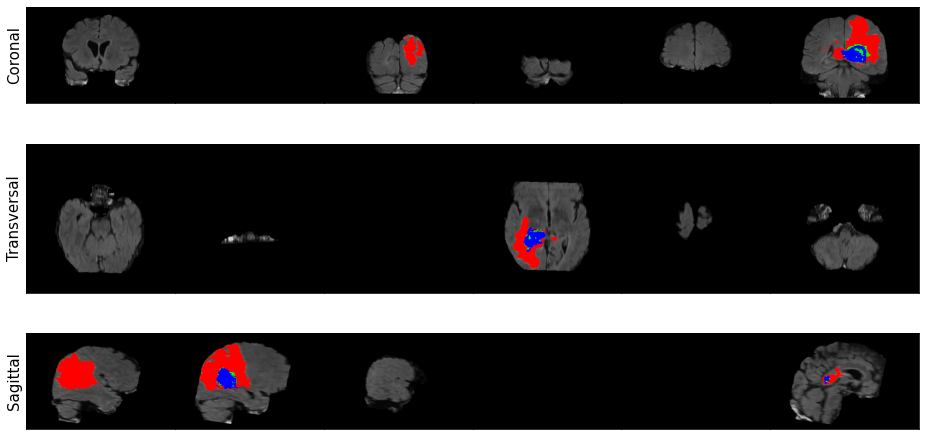

In [49]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_003.nii.gz", DATA_DIR + "labelsTr/BRATS_003.nii.gz")
image = get_labeled_image(image, label)

plot_image_grid(image)

In [50]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_003.nii.gz", DATA_DIR + "labelsTr/BRATS_003.nii.gz")
visualize_data_gif(get_labeled_image(image, label))

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_sub_volume(image, label, 
                   orig_x = 240, orig_y = 240, orig_z = 155, 
                   output_x = 160, output_y = 160, output_z = 16,
                   num_classes = 4, max_tries = 1000, 
                   background_threshold=0.95):
    """
    Extract random sub-volume from original images.

    Args:
        image (np.array): original image, 
            of shape (orig_x, orig_y, orig_z, num_channels)
        label (np.array): original label. 
            labels coded using discrete values rather than
            a separate dimension, 
            so this is of shape (orig_x, orig_y, orig_z)
        orig_x (int): x_dim of input image
        orig_y (int): y_dim of input image
        orig_z (int): z_dim of input image
        output_x (int): desired x_dim of output
        output_y (int): desired y_dim of output
        output_z (int): desired z_dim of output
        num_classes (int): number of class labels
        max_tries (int): maximum trials to do when sampling
        background_threshold (float): limit on the fraction 
            of the sample which can be the background

    returns:
        X (np.array): sample of original image of dimension 
            (num_channels, output_x, output_y, output_z)
        y (np.array): labels which correspond to X, of dimension 
            (num_classes, output_x, output_y, output_z)
    """
    # Initialize features and labels with `None`
    X = None
    y = None

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    tries = 0
    
    while tries < max_tries:
        # randomly sample sub-volume by sampling the corner voxel
        # hint: make sure to leave enough room for the output dimensions!
        start_x = np.random.randint(orig_x - output_x + 1 )
        start_y = np.random.randint(orig_y - output_y + 1 )
        start_z = np.random.randint(orig_z - output_z + 1 )

        # extract relevant area of label
        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]
        
        # One-hot encode the categories.
        # This adds a 4th dimension, 'num_classes'
        # (output_x, output_y, output_z, num_classes)
        y = keras.utils.to_categorical(y, num_classes)

        # compute the background ratio
        bgrd_ratio = y[:,:,:, 0].sum() / (output_x * output_y * output_z)

        # increment tries counter
        tries += 1

        # if background ratio is below the desired threshold,
        # use that sub-volume.
        # otherwise continue the loop and try another random sub-volume
        if bgrd_ratio < background_threshold:

            # make copy of the sub-volume
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z, :])
            
            # change dimension of X
            # from (x_dim, y_dim, z_dim, num_channels)
            # to (num_channels, x_dim, y_dim, z_dim)
            X = np.moveaxis(X, -1, 0)

            # change dimension of y
            # from (x_dim, y_dim, z_dim, num_classes)
            # to (num_classes, x_dim, y_dim, z_dim)
            y = np.moveaxis(y, -1, 0)

            ### END CODE HERE ###
            
            # take a subset of y that excludes the background class
            # in the 'num_classes' dimension
            y = y[1:, :, :, :]
    
            return X, y

    # if we've tried max_tries number of samples
    # Give up in order to avoid looping forever.
    print(f"Tried {tries} times to find a sub-volume. Giving up...")

In [52]:
np.random.seed(3)

image = np.zeros((4, 4, 3, 1))
label = np.zeros((4, 4, 3))

for i in range(4):
    for j in range(4):
        for k in range(3):
            image[i, j, k, 0] = i*j*k
            label[i, j, k] = k

print("image:")

for k in range(3):
    print(f"z = {k}")
    print(image[:, :, k, 0])

print("\n")
print("label:")

for k in range(3):
    print(f"z = {k}")
    print(label[:, :, k])

image:
z = 0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
z = 1
[[0. 0. 0. 0.]
 [0. 1. 2. 3.]
 [0. 2. 4. 6.]
 [0. 3. 6. 9.]]
z = 2
[[ 0.  0.  0.  0.]
 [ 0.  2.  4.  6.]
 [ 0.  4.  8. 12.]
 [ 0.  6. 12. 18.]]


label:
z = 0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
z = 1
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
z = 2
[[2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]]


In [53]:
sample_image, sample_label = get_sub_volume(image, 
                                            label,
                                            orig_x=4, 
                                            orig_y=4, 
                                            orig_z=3,
                                            output_x=2, 
                                            output_y=2, 
                                            output_z=2,
                                            num_classes = 3)

print("Sampled Image:")

for k in range(2):
    print("z = " + str(k))
    print(sample_image[0, :, :, k])

Sampled Image:
z = 0
[[0. 2.]
 [0. 3.]]
z = 1
[[0. 4.]
 [0. 6.]]


In [54]:
print("Sampled Label:")

for c in range(2):
    print("class = " + str(c))
    for k in range(2):
        print("z = " + str(k))
        print(sample_label[c, :, :, k])

Sampled Label:
class = 0
z = 0
[[1. 1.]
 [1. 1.]]
z = 1
[[0. 0.]
 [0. 0.]]
class = 1
z = 0
[[0. 0.]
 [0. 0.]]
z = 1
[[1. 1.]
 [1. 1.]]


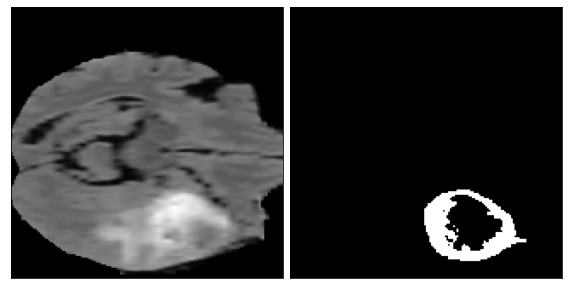

In [55]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_001.nii.gz", DATA_DIR + "labelsTr/BRATS_001.nii.gz")
X, y = get_sub_volume(image, label)

# enhancing tumor is channel 2 in the class label
# you can change indexer for y to look at different classes
visualize_patch(X[0, :, :, :], y[2])

In [0]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def standardize(image):
    """
    Standardize mean and standard deviation 
        of each channel and z_dimension.

    Args:
        image (np.array): input image, 
            shape (num_channels, dim_x, dim_y, dim_z)

    Returns:
        standardized_image (np.array): standardized version of input image
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # initialize to array of zeros, with same shape as the image
    standardized_image = np.empty(image.shape)

    # iterate over channels
    for c in range(image.shape[0]):
        # iterate over the `z` dimension
        for z in range(image.shape[3]):
            # get a slice of the image 
            # at channel c and z-th dimension `z`
            image_slice = image[c,:,:,z]

            # subtract the mean from image_slice
            centered = image_slice - image_slice.mean()
            
            if image_slice.std() != 0:
                centered_scaled = image_slice / image_slice.std()
            else:
                centered_scaled = centered
                

            # update  the slice of standardized image
            # with the scaled centered and scaled image
            standardized_image[c, :, :, z] = centered_scaled

    ### END CODE HERE ###

    return standardized_image

In [57]:
X_norm = standardize(X)

print("standard deviation for a slice should be 1.0")
print(f"stddv for X_norm[0, :, :, 0]: {X_norm[0,:,:,0].std():.2f}")

standard deviation for a slice should be 1.0
stddv for X_norm[0, :, :, 0]: 1.00


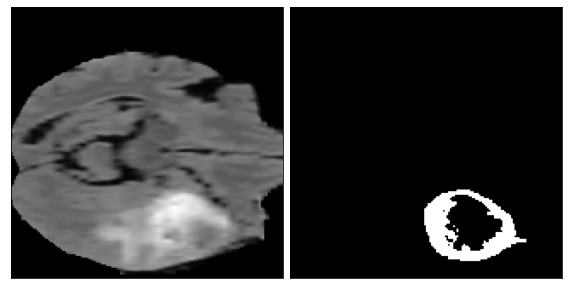

In [58]:
visualize_patch(X_norm[0, :, :, :], y[2])

In [0]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def single_class_dice_coefficient(y_true, y_pred, axis=(0, 1, 2), 
                                  epsilon=0.00001):
    """
    Compute dice coefficient for single class.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for single class.
                                    shape: (x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for single class.
                                    shape: (x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum function.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    dice_numerator = K.sum(2 * y_true * y_pred, axis= axis) + epsilon
    dice_denominator = K.sum(y_true,axis= axis) + K.sum(y_pred, axis = axis) + epsilon
    dice_coefficient = dice_numerator / dice_denominator 
    
    ### END CODE HERE ###

    return dice_coefficient

In [60]:
# TEST CASES
# sess = K.get_session()

sess = tf.compat.v1.Session()
tf.compat.v1.disable_eager_execution()

with sess.as_default() as sess:
    pred = np.expand_dims(np.eye(2), -1)
    label = np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), -1)

    print("Test Case #1")
    print("pred:")
    print(pred[:, :, 0])
    print("label:")
    print(label[:, :, 0])

    # choosing a large epsilon to help check for implementation errors
    dc = single_class_dice_coefficient(pred, label,epsilon=1)
    print(f"dice coefficient: {dc.eval():.4f}")

    print("\n")

    print("Test Case #2")
    pred = np.expand_dims(np.eye(2), -1)
    label = np.expand_dims(np.array([[1.0, 1.0], [0.0, 1.0]]), -1)

    print("pred:")
    print(pred[:, :, 0])
    print("label:")
    print(label[:, :, 0])

    # choosing a large epsilon to help check for implementation errors
    dc = single_class_dice_coefficient(pred, label,epsilon=1)
    print(f"dice_coefficient: {dc.eval():.4f}")

Test Case #1
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 0.]]
dice coefficient: 0.6000


Test Case #2
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 1.]]
dice_coefficient: 0.8333


In [0]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):
    """
    Compute mean dice coefficient over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant add to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    dice_numerator = K.sum(2 * y_true * y_pred, axis= axis) + epsilon
    dice_denominator = K.sum(y_true,axis= axis) + K.sum(y_pred, axis = axis) + epsilon
    dice_coefficient = K.mean(dice_numerator / dice_denominator,axis = 0)
    
    ### END CODE HERE ###

    return dice_coefficient

In [62]:
# TEST CASES
sess = tf.compat.v1.Session()
tf.compat.v1.disable_eager_execution()

with sess.as_default() as sess:
    pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
    label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), 0), -1)

    print("Test Case #1")
    print("pred:")
    print(pred[0, :, :, 0])
    print("label:")
    print(label[0, :, :, 0])

    dc = dice_coefficient(pred, label,epsilon=1)
    print(f"dice coefficient: {dc.eval():.4f}")

    print("\n")

    print("Test Case #2")
    pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
    label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 1.0]]), 0), -1)


    print("pred:")
    print(pred[0, :, :, 0])
    print("label:")
    print(label[0, :, :, 0])

    dc = dice_coefficient(pred, label,epsilon=1)
    print(f"dice coefficient: {dc.eval():.4f}")
    print("\n")


    print("Test Case #3")
    pred = np.zeros((2, 2, 2, 1))
    pred[0, :, :, :] = np.expand_dims(np.eye(2), -1)
    pred[1, :, :, :] = np.expand_dims(np.eye(2), -1)
    
    label = np.zeros((2, 2, 2, 1))
    label[0, :, :, :] = np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), -1)
    label[1, :, :, :] = np.expand_dims(np.array([[1.0, 1.0], [0.0, 1.0]]), -1)

    print("pred:")
    print("class = 0")
    print(pred[0, :, :, 0])
    print("class = 1")
    print(pred[1, :, :, 0])
    print("label:")
    print("class = 0")
    print(label[0, :, :, 0])
    print("class = 1")
    print(label[1, :, :, 0])

    dc = dice_coefficient(pred, label,epsilon=1)
    print(f"dice coefficient: {dc.eval():.4f}")

Test Case #1
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 0.]]
dice coefficient: 0.6000


Test Case #2
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 1.]]
dice coefficient: 0.8333


Test Case #3
pred:
class = 0
[[1. 0.]
 [0. 1.]]
class = 1
[[1. 0.]
 [0. 1.]]
label:
class = 0
[[1. 1.]
 [0. 0.]]
class = 1
[[1. 1.]
 [0. 1.]]
dice coefficient: 0.7167


In [0]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    dice_numerator = 2 * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(K.square(y_true), axis = axis) + K.sum(K.square(y_pred), axis = axis) + epsilon
    dice_loss = 1 - K.mean(dice_numerator / dice_denominator, axis = 0)

    ### END CODE HERE ###

    return dice_loss

In [64]:
# TEST CASES

sess = tf.compat.v1.Session()
tf.compat.v1.disable_eager_execution()

with sess.as_default() as sess:
    pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
    label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), 0), -1)

    print("Test Case #1")
    print("pred:")
    print(pred[0, :, :, 0])
    print("label:")
    print(label[0, :, :, 0])

    dc = soft_dice_loss(pred, label, epsilon=1)
    print(f"soft dice loss:{dc.eval():.4f}")

Test Case #1
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 0.]]
soft dice loss:0.4000


In [65]:
sess = tf.compat.v1.Session()
tf.compat.v1.disable_eager_execution()

with sess.as_default() as sess:
    pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
    label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), 0), -1)
    
    print("Test Case #2")
    pred = np.expand_dims(np.expand_dims(0.5*np.eye(2), 0), -1)
    print("pred:")
    print(pred[0, :, :, 0])
    print("label:")
    print(label[0, :, :, 0])
    dc = soft_dice_loss(pred, label, epsilon=1)
    print(f"soft dice loss: {dc.eval():.4f}")

Test Case #2
pred:
[[0.5 0. ]
 [0.  0.5]]
label:
[[1. 1.]
 [0. 0.]]
soft dice loss: 0.4286


In [66]:
sess = tf.compat.v1.Session()
tf.compat.v1.disable_eager_execution()

with sess.as_default() as sess:
    pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
    label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), 0), -1)
    
    print("Test Case #3")
    pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
    label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 1.0]]), 0), -1)

    print("pred:")
    print(pred[0, :, :, 0])
    print("label:")
    print(label[0, :, :, 0])

    dc = soft_dice_loss(pred, label, epsilon=1)
    print(f"soft dice loss: {dc.eval():.4f}")

Test Case #3
pred:
[[1. 0.]
 [0. 1.]]
label:
[[1. 1.]
 [0. 1.]]
soft dice loss: 0.1667


In [67]:
sess = tf.compat.v1.Session()
tf.compat.v1.disable_eager_execution()

with sess.as_default() as sess:
    pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
    label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), 0), -1)

    print("Test Case #4")
    pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
    pred[0, 0, 1, 0] = 0.8
    label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 1.0]]), 0), -1)

    print("pred:")
    print(pred[0, :, :, 0])
    print("label:")
    print(label[0, :, :, 0])

    dc = soft_dice_loss(pred, label, epsilon=1)
    print(f"soft dice loss: {dc.eval():.4f}")

Test Case #4
pred:
[[1.  0.8]
 [0.  1. ]]
label:
[[1. 1.]
 [0. 1.]]
soft dice loss: 0.0060


In [68]:
sess = tf.compat.v1.Session()
tf.compat.v1.disable_eager_execution()

with sess.as_default() as sess:
    pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
    label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), 0), -1)
    
    print("Test Case #5")
    pred = np.zeros((2, 2, 2, 1))
    pred[0, :, :, :] = np.expand_dims(0.5*np.eye(2), -1)
    pred[1, :, :, :] = np.expand_dims(np.eye(2), -1)
    pred[1, 0, 1, 0] = 0.8

    label = np.zeros((2, 2, 2, 1))
    label[0, :, :, :] = np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), -1)
    label[1, :, :, :] = np.expand_dims(np.array([[1.0, 1.0], [0.0, 1.0]]), -1)

    print("pred:")
    print("class = 0")
    print(pred[0, :, :, 0])
    print("class = 1")
    print(pred[1, :, :, 0])
    print("label:")
    print("class = 0")
    print(label[0, :, :, 0])
    print("class = 1")
    print(label[1, :, :, 0])

    dc = soft_dice_loss(pred, label, epsilon=1)
    print(f"soft dice loss: {dc.eval():.4f}")

Test Case #5
pred:
class = 0
[[0.5 0. ]
 [0.  0.5]]
class = 1
[[1.  0.8]
 [0.  1. ]]
label:
class = 0
[[1. 1.]
 [0. 0.]]
class = 1
[[1. 1.]
 [0. 1.]]
soft dice loss: 0.2173


In [69]:
# Test case 6
pred = np.array([
                    [
                        [ 
                            [1.0, 1.0], [0.0, 0.0]
                        ],
                        [
                            [1.0, 0.0], [0.0, 1.0]
                        ]
                    ],
                    [
                        [ 
                            [1.0, 1.0], [0.0, 0.0]
                        ],
                        [
                            [1.0, 0.0], [0.0, 1.0]
                        ]
                    ],
                  ])
label = np.array([
                    [
                        [ 
                            [1.0, 0.0], [1.0, 0.0]
                        ],
                        [
                            [1.0, 0.0], [0.0, 0.0]
                        ]
                    ],
                    [
                        [ 
                            [0.0, 0.0], [0.0, 0.0]
                        ],
                        [
                            [1.0, 0.0], [0.0, 0.0]
                        ]
                    ]
                  ])

sess = tf.compat.v1.Session()
tf.compat.v1.disable_eager_execution()

print("Test case #6")

with sess.as_default() as sess:
    dc = soft_dice_loss(pred, label, epsilon=1)
    print(f"soft dice loss",dc.eval())

Test case #6
soft dice loss 0.4375


In [70]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.2.0
tf.keras.__version__ is: 2.3.0-tf


In [0]:
model = unet_model_3d(loss_function=soft_dice_loss, metrics=[dice_coefficient])

In [0]:
# # Run this on your local machine only
# # May cause the kernel to die if running in the Coursera platform

# base_dir = HOME_DIR + "processed/"

# with open(base_dir + "config.json") as json_file:
#     config = json.load(json_file)

# # Get generators for training and validation sets
# train_generator = VolumeDataGenerator(config["train"], base_dir + "train/", batch_size=16, dim=(160, 160, 16), verbose=0)
# valid_generator = VolumeDataGenerator(config["valid"], base_dir + "valid/", batch_size=16, dim=(160, 160, 16), verbose=0)

# steps_per_epoch = 20
# n_epochs = 10
# validation_steps = 20

# model.fit_generator(generator=train_generator,
#         steps_per_epoch=steps_per_epoch,
#         epochs=n_epochs,
#         use_multiprocessing=True,
#         validation_data=valid_generator,
#         validation_steps=validation_steps)

# # run this cell if you to save the weights of your trained model in cell section 4.1
# #model.save_weights(base_dir + 'my_model_pretrained.hdf5')

In [0]:
# run this cell if you didn't run the training cell in section 4.1
base_dir = HOME_DIR + "processed/"

with open(base_dir + "config.json") as json_file:
    config = json.load(json_file)

# Get generators for training and validation sets
train_generator = VolumeDataGenerator(config["train"], base_dir + "train/", batch_size=3, dim=(160, 160, 16), verbose=0)
valid_generator = VolumeDataGenerator(config["valid"], base_dir + "valid/", batch_size=3, dim=(160, 160, 16), verbose=0)

In [0]:
model.load_weights("model_pretrained.hdf5")

In [0]:
model.summary()

In [0]:
val_loss, val_dice = model.evaluate_generator(valid_generator)

print(f"validation soft dice loss: {val_loss:.4f}")
print(f"validation dice coefficient: {val_dice:.4f}")

In [0]:
visualize_patch(X_norm[0, :, :, :], y[2])

In [0]:
X_norm_with_batch_dimension = np.expand_dims(X_norm, axis=0)
patch_pred = model.predict(X_norm_with_batch_dimension)

In [0]:
# set threshold.
threshold = 0.5

# use threshold to get hard predictions
patch_pred[patch_pred > threshold] = 1.0
patch_pred[patch_pred <= threshold] = 0.0

In [0]:
print("Patch and ground truth")
util.visualize_patch(X_norm[0, :, :, :], y[2])
plt.show()

print("Patch and prediction")
util.visualize_patch(X_norm[0, :, :, :], patch_pred[0, 2, :, :, :])
plt.show()

In [0]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def compute_class_sens_spec(pred, label, class_num):
    """
    Compute sensitivity and specificity for a particular example
    for a given class.

    Args:
        pred (np.array): binary arrary of predictions, shape is
                         (num classes, height, width, depth).
        label (np.array): binary array of labels, shape is
                          (num classes, height, width, depth).
        class_num (int): number between 0 - (num_classes -1) which says
                         which prediction class to compute statistics
                         for.

    Returns:
        sensitivity (float): precision for given class_num.
        specificity (float): recall for given class_num
    """

    # extract sub-array for specified class
    class_pred = pred[class_num]
    class_label = label[class_num]

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute:
    
    # true positives
    tp = np.sum((class_label == 1) & (class_pred == 1))

    # true negatives
    tn = np.sum((class_label == 0) & (class_pred == 0))
    
    #false positives
    fp = np.sum((class_label == 0) & (class_pred == 1))
    
    # false negatives
    fn = np.sum((class_label == 1) & (class_pred == 0))

    # compute sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    ### END CODE HERE ###

    return sensitivity, specificity

In [0]:
# TEST CASES
pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 0.0]]), 0), -1)

print("Test Case #1")
print("pred:")
print(pred[0, :, :, 0])
print("label:")
print(label[0, :, :, 0])

sensitivity, specificity = compute_class_sens_spec(pred, label, 0)
print(f"sensitivity: {sensitivity:.4f}")
print(f"specificity: {specificity:.4f}")

In [0]:
print("Test Case #2")

pred = np.expand_dims(np.expand_dims(np.eye(2), 0), -1)
label = np.expand_dims(np.expand_dims(np.array([[1.0, 1.0], [0.0, 1.0]]), 0), -1)

print("pred:")
print(pred[0, :, :, 0])
print("label:")
print(label[0, :, :, 0])

sensitivity, specificity = compute_class_sens_spec(pred, label, 0)
print(f"sensitivity: {sensitivity:.4f}")
print(f"specificity: {specificity:.4f}")

In [0]:
# Note: we must explicity import 'display' in order for the autograder to compile the submitted code
# Even though we could use this function without importing it, keep this import in order to allow the grader to work
from IPython.display import display
print("Test Case #3")

df = pd.DataFrame({'y_test': [1,1,0,0,0,0,0,0,0,1,1,1,1,1],
                   'preds_test': [1,1,0,0,0,1,1,1,1,0,0,0,0,0],
                   'category': ['TP','TP','TN','TN','TN','FP','FP','FP','FP','FN','FN','FN','FN','FN']
                  })

display(df)
pred = np.array( [df['preds_test']])
label = np.array( [df['y_test']])

sensitivity, specificity = compute_class_sens_spec(pred, label, 0)
print(f"sensitivity: {sensitivity:.4f}")
print(f"specificity: {specificity:.4f}")

In [0]:
sensitivity, specificity = compute_class_sens_spec(patch_pred[0], y, 2)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

In [0]:
def get_sens_spec_df(pred, label):
    patch_metrics = pd.DataFrame(
        columns = ['Edema', 
                   'Non-Enhancing Tumor', 
                   'Enhancing Tumor'], 
        index = ['Sensitivity',
                 'Specificity'])
    
    for i, class_name in enumerate(patch_metrics.columns):
        sens, spec = compute_class_sens_spec(pred, label, i)
        patch_metrics.loc['Sensitivity', class_name] = round(sens,4)
        patch_metrics.loc['Specificity', class_name] = round(spec,4)

    return patch_metrics

In [0]:
df = get_sens_spec_df(patch_pred[0], y)

print(df)

In [0]:
# uncomment this code to run it
# image, label = load_case(DATA_DIR + "imagesTr/BRATS_001.nii.gz", DATA_DIR + "labelsTr/BRATS_001.nii.gz")
# pred = util.predict_and_viz(image, label, model, .5, loc=(130, 130, 77))

In [0]:
import sys
sys.getsizeof(image) / 1000  / 1000

In [0]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_003.nii.gz", DATA_DIR + "labelsTr/BRATS_003.nii.gz")
pred = util.predict_and_viz(image, label, model, .5, loc=(130, 130, 77))

In [0]:
whole_scan_label = keras.utils.to_categorical(label, num_classes = 4)
whole_scan_pred = pred

# move axis to match shape expected in functions
whole_scan_label = np.moveaxis(whole_scan_label, 3 ,0)[1:4]
whole_scan_pred = np.moveaxis(whole_scan_pred, 3, 0)[1:4]

In [0]:
whole_scan_df = get_sens_spec_df(whole_scan_pred, whole_scan_label)

print(whole_scan_df)